# Handwritten Digits Recognition with a Convolutional Neural Network [LeNet-5] (Using Tensorflow)

## Overview
**The DataSet** : The MNIST database of handwritten digits, available from this page : http://yann.lecun.com/exdb/mnist/index.html, has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image, with a dimension of 28 by 28 and a single channel (since it's in gray scale). The database is labeled with numerical values ranging from 0 to 9 (10 classes).  

**The Task** : Build a multi-classification model that predicts the label of a 28*28 image of a handwritten digit.  




## Loading & Preparing the dataset 

Shape of training data : shape(X) = (60000, 28, 28), shape(Y) = (60000,)
Shape of test data : shape(X) = (10000, 28, 28), shape(Y) = (10000,)


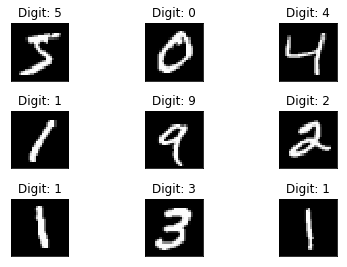

In [19]:
#Loading Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.utils as kut

#Loading data
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#Plotting some examples
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(train_images[i,], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(train_labels[i,]))
  plt.xticks([])
  plt.yticks([])

#Overview of data shapes
print("Shape of training data : shape(X) = "+str(train_images.shape) + ", shape(Y) = "+str(train_labels.shape))
print("Shape of test data : shape(X) = "+str(test_images.shape) + ", shape(Y) = "+str(test_labels.shape))

Before moving to the model, we start first by scaling up the dataset's images to take values in (0,1). We also turn the labels to categorical variables with one-hot encoding to follow the LeNet-5 architecture and use a softmax loss function.

In [20]:
#Scaling Up images
train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255

train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

#Turning the labels into categorical variables (One-hot encoding)
train_labels = kut.to_categorical(train_labels)
test_labels = kut.to_categorical(test_labels)

## Building the LeNet-5 Convolutional Neural Network

The figure below shows a simplified architecture of a **modern version of the LeNet-5 CNN**.

<img src="LeNet5_Architecture.png"> 

In [24]:
#Setting the Hyperparameters
n_C0 = 1             #Number of channels of the input
n_H0, n_W0 = 28, 28  #Height/Width of the input layer

n_H1, n_W1 = 5,5     #Height/Width of the first convolution filter
n_C1 = 6             #Number of channels of the 1st convolution layer (number of filters)

n_H2, n_W2 = 5,5     #Height/Width of the second convolution layer
n_C2 = 16            #Number of channels of the 2nd convolution layer (number of filters)

learning_rate = 0.005

#Setting constants
n_y = 10             #Number of classes (labels)


### Computational Graph Building

In [31]:

myGraph = tf.Graph()
with myGraph.as_default():
    
    #Placeholders
    with tf.name_scope("Placeholders"):
        X = tf.placeholder(dtype=tf.float32,shape=(None, n_H0, n_W0, n_C0))
        Y = tf.placeholder(dtype=tf.float32, shape=(None, n_y))
        
    #First Convolution Layer    
    with tf.name_scope("ConvLayer1"):
        W1 = tf.get_variable( "W1",shape = (n_H1, n_W1, n_C0, n_C1),initializer= tf.contrib.layers.xavier_initializer(seed = 19), dtype=tf.float32)
        B1 = tf.get_variable("B1", shape= (1,1,1,n_C1), initializer= tf.contrib.layers.xavier_initializer(seed = 13), dtype=tf.float32)
        Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME') #Same padding to keep same dimensions in the output
        A1 = tf.nn.relu(tf.nn.bias_add(Z1, tf.squeeze(B1)))
        P1 = tf.nn.max_pool(A1, ksize=[1,2,2,1],strides= [1,2,2,1], padding="SAME") #Same padding to keep same dimensions in the output
        
    #Second Convolution Layer
    with tf.name_scope("ConvLayer2"):
        W2 = tf.get_variable( "W2",shape = (n_H2, n_W2, n_C1, n_C2),initializer= tf.contrib.layers.xavier_initializer(seed = 19), dtype=tf.float32)
        B2 = tf.get_variable("B2", shape= (1,1,1,n_C2), initializer= tf.contrib.layers.xavier_initializer(seed = 10), dtype=tf.float32)
        Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'VALID')   #No padding
        A2 = tf.nn.relu(tf.nn.bias_add(Z2, tf.squeeze(B2)))
        P2 = tf.nn.max_pool(A2, ksize=[1,2,2,1],strides= [1,2,2,1], padding="VALID") #No padding
        P2 = tf.contrib.layers.flatten(P2)
        P2_shape = P2.get_shape().as_list()
        
    #Fully Connected Layer
    with tf.name_scope("FCLayer1"):
        Wfc1 = tf.get_variable("Wfc1", shape=(P2_shape[1],84), initializer=tf.truncated_normal_initializer(), dtype=tf.float32)
        bfc1 = tf.get_variable("bfc1", shape=(84,),initializer=tf.truncated_normal_initializer(), dtype=tf.float32 )
        Z3 = tf.matmul(P2, Wfc1)+bfc1
        A3 = tf.nn.relu(Z3)
    with tf.name_scope("FCLayer2"):
        Wfc2 = tf.get_variable("Wfc2", shape=(84,10), initializer=tf.truncated_normal_initializer(), dtype=tf.float32)
        bfc2 = tf.get_variable("bfc2", shape=(10,),initializer=tf.truncated_normal_initializer(), dtype=tf.float32 )
        Z4 = tf.matmul(A3, Wfc2)+bfc2
        predictions = tf.arg_max(Z4,1)
        
    #Loss function
    with tf.name_scope("cost"):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z4, labels=Y))
        
    #Optimizer
    with tf.name_scope("optimizer") :
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #Summaries for TensorBoard
    with tf.name_scope("summaries"):
        tf.summary.scalar("cost",cost)
        merged=tf.summary.merge_all()
        
    train_writer = tf.summary.FileWriter('/tmp/TB_CNN5', tf.get_default_graph()) 
    
    #Initializer
    initIt=tf.global_variables_initializer()    

        

## Model Training & Evaluation

step : 0, Average of minibatch's losses = 13.675859
step : 10, Average of minibatch's losses = 0.277974
step : 20, Average of minibatch's losses = 0.135502
step : 30, Average of minibatch's losses = 0.102907
step : 40, Average of minibatch's losses = 0.100315
Train Accuracy = 0.975467
Test Accuracy = 0.974200


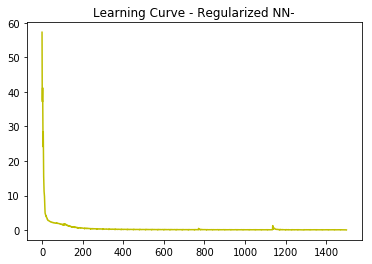

In [33]:
#Training Parameters
n_epoches = 50
batchSize = 2000

Sesso=tf.Session(graph=myGraph)
with tf.Session(graph=myGraph) as Sesso:
    losses=list()
    Sesso.run(initIt)
    j = 0
    for i in range(n_epoches):
        perEpochLoss = list()
        for batch in range(train_images.shape[0]//batchSize):
            miniBatchX, miniBatchY = train_images[batch*batchSize:(1+batch)*batchSize,], train_labels[batch*batchSize:(1+batch)*batchSize,]
            feed_dict={X:miniBatchX,Y:miniBatchY}
            _, summary, loss = Sesso.run([optimizer,merged ,cost], feed_dict=feed_dict)
            train_writer.add_summary(summary,j)
            perEpochLoss.append(loss)
            losses.append(loss)
            j = j+1
        perEpochLoss = np.mean(perEpochLoss)
        if (i%10 == 0):
            print("step : %d, Average of minibatch's losses = %f"%(i, perEpochLoss))
        
    w1_final, b1_final, W2_final, b2_final, wfc1_final, bfc1_final = Sesso.run([W1, B1,W2,B2, Wfc1,bfc1])
        
    #Predicting on train Data using optimal learned parameters
    preds = Sesso.run(predictions, feed_dict={X: train_images})
    #Train Accuracy
    accuracyTrain = np.sum(preds==np.argmax(train_labels,1))/len(train_labels)
    
    #Test Accuracy
    testPreds = Sesso.run(predictions, feed_dict = {X: test_images})  
    accuracyTest = np.sum(testPreds==np.argmax(test_labels,1))/len(test_labels)
    
    #Accuracies
    print("Train Accuracy = %f"%accuracyTrain)
    print("Test Accuracy = %f"%accuracyTest)
    
    
    #Plotting the Learning Curve
    plt.title("Learning Curve - CNN 'LeNet-5' -")
    plt.plot(losses,"y")

We get a test accuracy of 97% which is generally the average performance of the LeNet-5 architecture (Check the Yan LuCun's MNIST Website).  

## Graph Visualization  
TensorBoard is the best tool to visualize the graph and keep track of all its operations and tensors. This helps getting more sense of the model and it's also used as a debugging tool.  
To run TensorBoard, type the command below in the command line :  
> ** tensorboard --logdir=/tmp/TB_CNN5  **   

Once TensorBoard is running, we navigate the web browser to **localhost:6006** to view the TensorBoard. (By default adress).

In the TensorBoard page, we can see the navigation tabs in the top right corner. Each tab represents a set of serialized data that can be visualized.

*For more informations on how to use the graph tab to visualize TF graphs, check this link :  https://www.tensorflow.org/guide/graph_viz *  

Here is a screenshot of a summarized view of the graph we ran in this tuorial :  

<img src="graph_simple_cnn.png"> 

                                                
                                                              ** Completed on Wednesday August 29 **
                                                                 ** @Author : Ouadie EL FAROUKI **